# Movie Frames Embedding

In [1]:
%matplotlib inline

In [2]:
data_dir = 'data'
movie = 'us-daily-precipitation.mp4'
fps = 5
frame_width = 320
frame_height = 240

In [3]:
movie_name = movie.split('.')[0]
frames_dir = f'{data_dir}/{movie_name}'
outfile = f'{data_dir}/{movie_name}.json'

## Extract frames

In [4]:
import subprocess

subprocess.run([f'mkdir -p {frames_dir}'], shell=True, check=True)

CompletedProcess(args=['mkdir -p data/us-daily-precipitation'], returncode=0)

In [5]:
subprocess.run(
    [f'ffmpeg -i {data_dir}/{movie} -f image2 -vf fps={fps} -s {frame_width}*{frame_height} {frames_dir}/%03d.png'],
    shell=True,
    check=True
)

CompletedProcess(args=['ffmpeg -i data/us-daily-precipitation.mp4 -f image2 -vf fps=5 -s 320*240 data/us-daily-precipitation/%03d.png'], returncode=0)

## Load images in gray scale

In [6]:
import imageio
import numpy as np
import os

frame_imgs = os.listdir(frames_dir)

frame_imgs.sort(key=str.lower)

frame_imgs = frame_imgs[4:365 + 4]
num_frames = len(frame_imgs)
frames = []

# First 5 frames are the same so we start with the 4th frame and extract 365 frames for the whole year
for file_name in frame_imgs:
    name = f'{frames_dir}/{file_name}'
    frame = imageio.imread(name)
    frames.append(frame)

frames = np.asarray(frames)

### Remove the text label at the top

Only for the precipitation movie.

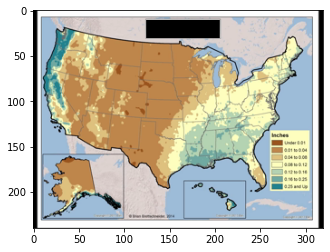

In [7]:
from matplotlib.pyplot import imshow

label_size = [20, 81] # i,j
label_pos = [11, 125] # i,j

# We set the label to black
frames[
    :,
    label_pos[0]:label_pos[0] + label_size[0],
    label_pos[1]:label_pos[1] + label_size[1],
    :
] = 0

imshow(frames[0])

frames_gray = np.copy(frames).mean(axis=3).astype(np.uint8).reshape((frames.shape[0], -1))
frames = frames.reshape((frames.shape[0], -1, 3))

## Compute mean absolute difference between frames

In [49]:
import numba
from scipy.spatial.distance import pdist, squareform

@numba.njit()
def mean_absolute_dist(a,b):
    return np.sum(np.abs(a - b)) / a.shape[0]

dist_gray = squareform(pdist(frames_gray, metric=mean_absolute_dist))

In [51]:
def hue(v):
    cmax = v.max(axis=1)
    cmin = v.min(axis=1)
    delta = (cmax - cmin).astype(np.float64)
    
    cmax_r = cmax==v[:, 0]
    cmax_g = cmax==v[:, 1]
    cmax_b = cmax==v[:, 2]
    
    x = np.zeros_like(v[:, 0]).astype(np.float64)
    x[cmax_r] = v[cmax_r, 1] - v[cmax_r, 2]
    x[cmax_g] = v[cmax_g, 2] - v[cmax_g, 0]
    x[cmax_b] = v[cmax_b, 0] - v[cmax_b, 1]
    
    x = np.divide(x, delta, out=np.zeros_like(x), where=delta!=0)
    
    x[cmax_r] %= 6
    x[cmax_g] += 2
    x[cmax_b] += 4
    
    return x

def lightness(v):
    cmax = v.max(axis=1)
    cmin = v.min(axis=1)
    return (cmax + cmin) / 2.0

def saturation(v):
    cmax = v.max(axis=1)
    cmin = v.min(axis=1)
    chroma = (cmax - cmin).astype(np.float64)
    light = lightness(v)
    light = (1 - np.abs(2 * light - 1))
    return np.divide(chroma, light, out=np.zeros_like(chroma), where=light!=0)

def hsl_dist(a, b):
    a_sat = saturation(a)
    b_sat = saturation(b)
    a_light = lightness(a)
    b_light = lightness(b)
    a_hue = hue(a)
    b_hue = hue(b)
    return (a_sat - b_sat)**2 + (a_light - b_light)**2 + (((a_hue - b_hue) % 6) / 6.0)

dist_hsl = np.zeros((num_frames, num_frames))
frame_dim = 240*320

for i in np.arange(num_frames):
    print(f'{i}, ', end='', flush=True)
    for j in np.arange(i + 1, num_frames):
        dist = np.sum(np.abs(hsl_dist(frames[i], frames[j]))) / frame_dim

        dist_hsl[i,j] = dist
        dist_hsl[j,i] = dist
print('done!')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

## Compute embedding with distance matrix

In [55]:
from umap import UMAP
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import MinMaxScaler

mds_gray = MDS(dissimilarity='precomputed', n_jobs=-1).fit_transform(dist_gray)
tsne_gray = TSNE(metric='precomputed', n_jobs=-1).fit_transform(dist_gray)
umap_gray = UMAP(n_neighbors=int(num_frames/12), metric='precomputed').fit_transform(dist_gray)

mds_hsl = MDS(dissimilarity='precomputed', n_jobs=-1).fit_transform(dist_hsl)
tsne_hsl = TSNE(metric='precomputed', n_jobs=-1).fit_transform(dist_hsl)
umap_hsl = UMAP(n_neighbors=int(num_frames/12), metric='precomputed').fit_transform(dist_hsl)

## Scale embeddings

To add some padding we scale the data to `[0.1, 0.9]`.

In [56]:
scaler = MinMaxScaler((0.1, 0.9))

mds_scale_gray = scaler.fit_transform(mds_gray)
tsne_scale_gray = scaler.fit_transform(t_sne_gray)
umap_scale_gray = scaler.fit_transform(u_map_gray)

mds_scale_hsl = scaler.fit_transform(mds_hsl)
tsne_scale_hsl = scaler.fit_transform(t_sne_hsl)
umap_scale_hsl = scaler.fit_transform(u_map_hsl)

## Save data

In [57]:
import json

data = []

for i in range(num_frames):
    item = {}
    item['src'] = f'{frames_dir}/{frame_imgs[i]}'
    item['mds_gray'] = mds_scale_gray[i].tolist()
    item['tsne_gray'] = tsne_scale_gray[i].tolist()
    item['umap_gray'] = umap_scale_gray[i].tolist()
    item['mds_hsl'] = mds_scale_hsl[i].tolist()
    item['tsne_hsl'] = tsne_scale_hsl[i].tolist()
    item['umap_hsl'] = umap_scale_hsl[i].tolist()
    data.append(item)

with open(outfile, 'w') as f:
    json.dump(data, f)